# References

- https://www.ijidonline.com/article/S1201-9712(20)30117-X/fulltext
- https://discourse.julialang.org/t/modelling-covid-19-in-julia-and-plotting-agentbasedmodels-on-arbitrary-networks/36005
- https://discourse.julialang.org/t/my-crude-attempt-at-the-sir-model/33919/29
- https://discourse.julialang.org/t/simple-seir-model-for-simulating-covid-19-outbreak/35854
- https://github.com/berndblasius/Covid19/blob/master/src/Wang_SEIAHR.jl
- https://discourse.julialang.org/t/loading-covid-19-csv-data/35820

## DiffEq model

In [3]:
using DifferentialEquations, Plots

  0.982697 seconds (2.30 M allocations: 103.347 MiB, 1.03% gc time)


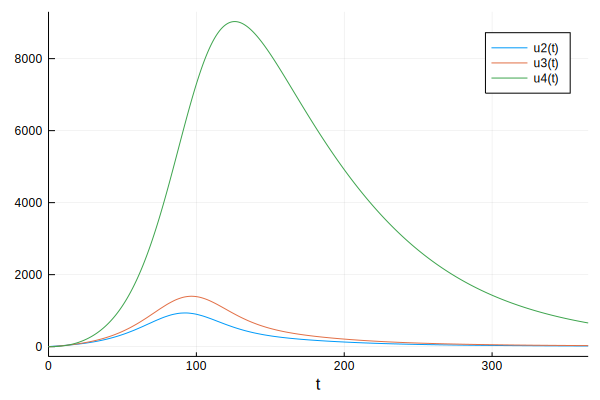

In [4]:
function corona!(du,u,p,t)
    S,E,I,R,N,D,C = u
    F, β0,α,κ,μ,σ,γ,d,λ = p
    du[1] = -β0*S*F/N - β(t,β0,D,N,κ,α)*S*I/N -μ*S # susceptible
    du[2] = β0*S*F/N + β(t,β0,D,N,κ,α)*S*I/N -(σ+μ)*E # exposed
    du[3] = σ*E - (γ+μ)*I # infected
    du[4] = γ*I - μ*R # removed (recovered + dead)
    du[5] = -μ*N # total population
    du[6] = d*γ*I - λ*D # severe, critical cases, and deaths
    du[7] = σ*E # +cumulative cases
end

β(t,β0,D,N,κ,α) = β0*(1-α)*(1-D/N)^κ
S0 = 14e6
u0 = [0.9*S0, 0.0, 0.0, 0.0, S0, 0.0, 0.0]
p = [10.0, 0.5944, 0.4239, 1117.3, 0.02, 1/3, 1/5,0.2, 1/11.2]
R0 = p[2]/p[7]*p[6]/(p[6]+p[5])
tspan = (0.0, 365.0)

prob = ODEProblem(corona!, u0, tspan, p)
@time sol = solve(prob, Tsit5())
plot(sol, vars=[2,3,4])

## RA model

In [1]:
using Revise, ReachabilityAnalysis, Plots
const RA = ReachabilityAnalysis

ReachabilityAnalysis

In [2]:
function corona2!(du,u,p,t)
    S,E,I,R,N,D,C = u
    F, β0,α,κ,μ,σ,γ,d,λ = [10.0, 0.5944, 0.4239, 1117.3, 0.02, 1/3, 1/5,0.2, 1/11.2]
    du[1] = -β0*S*F/N - β(t,β0,D,N,κ,α)*S*I/N -μ*S # susceptible
    du[2] = β0*S*F/N + β(t,β0,D,N,κ,α)*S*I/N -(σ+μ)*E # exposed
    du[3] = σ*E - (γ+μ)*I # infected
    du[4] = γ*I - μ*R # removed (recovered + dead)
    du[5] = -μ*N # total population
    du[6] = d*γ*I - λ*D # severe, critical cases, and deaths
    du[7] = σ*E # +cumulative cases
end
β(t,β0,D,N,κ,α) = β0*(1-α)*(1-D/N)^κ

S0 = 14e6
u0 = [0.9*S0, 0.0, 0.0, 0.0, S0, 0.0, 0.0]
rad = [0.9*S0 * 0.05, 0.0, 0.0, 0.0, S0 * 0.05, 0.0, 0.0]
X0 = Hyperrectangle(u0, rad)

# p = [10.0, 0.5944, 0.4239, 1117.3, 0.02, 1/3, 1/5,0.2, 1/11.2]

f = @system(x' = corona2!(x), dim: 7)
prob = InitialValueProblem(f, X0)

Singleton{Float64,Array{Float64,1}}([1.26e7, 0.0, 0.0, 0.0, 1.4e7, 0.0, 0.0])

In [24]:
@time sol = RA.solve(prob, tspan=(0.0, 365), TMJets(abs_tol=1e-18, max_steps=10_000));

237.621810 seconds (2.39 G allocations: 222.163 GiB, 22.51% gc time)


In [26]:
proj = overapproximate(sol, Zonotope);
#plot(sol, vars=[2,3,4])

In [27]:
plot(proj, vars=(0, 2))

# 5% variation in the initial condition

In [ ]:
u0 = [0.9*S0, 0.0, 0.0, 0.0, S0, 0.0, 0.0]
rad = [0.9*S0 * 0.05, 0.0, 0.0, 0.0, S0 * 0.05, 0.0, 0.0]
X0 = Hyperrectangle(u0, rad)
prob = InitialValueProblem(f, X0)

@time sol5pc = RA.solve(prob, tspan=(0.0, 365), TMJets(abs_tol=1e-18, max_steps=10_000));

In [ ]:
proj = overapproximate(sol5pc, Zonotope);

In [ ]:
plot(proj, vars=(0, 2))